# Hyperparameters tuning by grid search
In this example we will demonstrate how to perform grid search on the coreset tree. 

The results are compared with those obtained using GridSearchCV class from scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

For the experiments, Covertype Data Set is used (http://archive.ics.uci.edu/ml/datasets/covertype) 

Note that the notebook may take a long time to run (e.g., 40-60 minutes). Running grid search on the full dataset takes most of the notebook’s time. On the coreset in runs in a few minutes.

In [1]:
import itertools
import collections
import warnings
import numpy as np
import pandas as pd
from time import time
from contextlib import redirect_stdout
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import balanced_accuracy_score, make_scorer
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from dataheroes import CoresetTreeServiceDTC
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

### Prepare the datasets

In [3]:
X, y = fetch_covtype(return_X_y=True)
# Label-Encode the target. We do so because, further down the road, we will use XGBoost for
# modeling, which requires consecutive integer labels starting from 0
label_enc = LabelEncoder()
y = label_enc.fit_transform(y)
# Apply standard scaling on the X
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Split into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
print(f"#classes={len(np.unique(y))}, train dataset size={len(X_train):,}, test dataset size={len(X_test):,}")

#classes=7, train dataset size=406,708, test dataset size=174,304


###  Build the tree
Initialize the service and build the tree.

The tree uses the local file system to store its data.

After this step you will have a new directory .dataheroes_cache.

In [4]:
n_instances = len(X_train)
start = time()
service_obj = CoresetTreeServiceDTC(
    optimized_for='training',
    n_instances=n_instances
)
service_obj.build(X_train, y_train)
end = time()
coreset_build_time = end - start
print(f"CoresetTreeServiceDTC construction lasted {coreset_build_time:.2f} seconds")

CoresetTreeServiceDTC construction lasted 6.55 seconds


### Plot the tree

{'training': WindowsPath('None/training_tree_20231117_160519.png')}

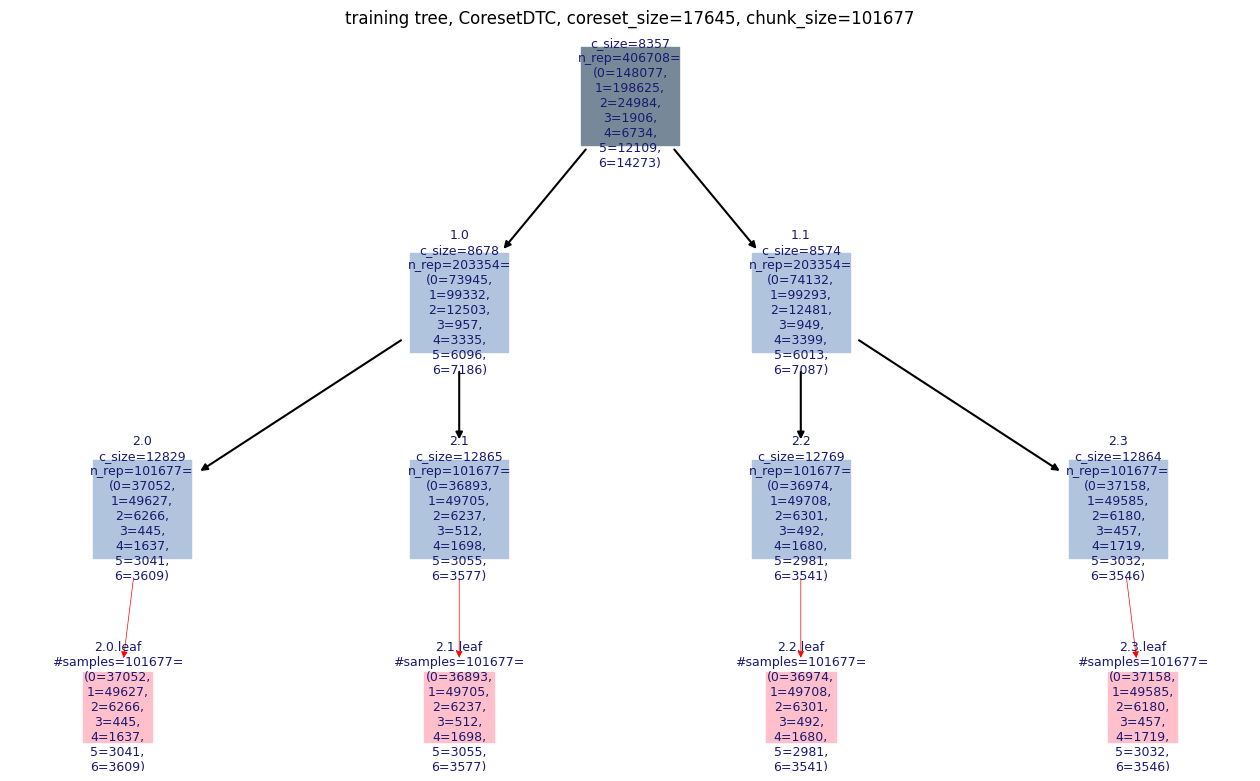

In [5]:
service_obj.plot()

### Define the hyperparameters grid and the scoring function

In [6]:
param_grid = {'lambda':[10, 100], 'max_depth':[3, 6]}
balanced_accuracy_scoring = make_scorer(balanced_accuracy_score)

### Perform grid search on the coreset tree

In [7]:
start = time()
optimal_hyperparameters, coreset_results_df, trained_model = service_obj.grid_search(param_grid=param_grid, scoring=balanced_accuracy_scoring, verbose=2)
end = time()
coreset_grid_search_time = end - start
y_pred = trained_model.predict(X_test)
coreset_best_params_test_score = balanced_accuracy_score(y_test, y_pred)
print(f'\nThe balanced accuracy score on the test data for the best hyperparameters is: {round(coreset_best_params_test_score, 4)}')
print(f'The optimal hyperparameters are: {optimal_hyperparameters}')
print(f"Grid search on the corset tree lasted {coreset_grid_search_time:.2f} seconds")

Fitting on level 2 with 4 folds for 4 hyperparameter combinations, totaling 16 fits
Using XGBClassifier model. To use a different model, please set the model parameter. E.g.: service_obj.fit(model=LGBMClassifier(**params), **other_params) or set the model_cls during init or use the set_model_cls function
Fold: 1/4; Hyperparameters: {'lambda': 10, 'max_depth': 3}; Score: 0.7111; Time: 1.593 (s).
Using XGBClassifier model. To use a different model, please set the model parameter. E.g.: service_obj.fit(model=LGBMClassifier(**params), **other_params) or set the model_cls during init or use the set_model_cls function
Fold: 1/4; Hyperparameters: {'lambda': 10, 'max_depth': 6}; Score: 0.8194; Time: 2.420 (s).
Using XGBClassifier model. To use a different model, please set the model parameter. E.g.: service_obj.fit(model=LGBMClassifier(**params), **other_params) or set the model_cls during init or use the set_model_cls function
Fold: 1/4; Hyperparameters: {'lambda': 100, 'max_depth': 3}; Score

In [8]:
coreset_results_df['mean_folds_score'] = coreset_results_df['mean_folds_score'].round(4)
validation_scores_coreset = coreset_results_df['mean_folds_score'].tolist()
coreset_results_df

,mean_folds_score,Fold 0,Fold 1,Fold 2,Fold 3,max_depth,lambda
0,0.7113,0.7111,0.7170,0.7068,0.7101,3,10
1,0.8202,0.8194,0.8231,0.8180,0.8203,6,10
2,0.7053,0.7051,0.7097,0.7029,0.7037,3,100
3,0.8126,0.8118,0.8119,0.8090,0.8177,6,100


### Perform grid search with a random sample
The random sample has the same size as the coreset 

The hyperparameters grid is the same

In [9]:
cv = 4  # Running 4-fold cross validation, same as the Coreset tree
model = XGBClassifier()
# Grid search was performed at the level 2 in the tree
# We find the size of the coreset in order to generate a random sample of equal size
coreset_obj = service_obj.get_coreset(level=2)
coreset_X = coreset_obj['data'][1]
coreset_size = len(coreset_X)
idx = np.random.choice(np.arange(len(X_train)), coreset_size, replace=False)
X_random = X_train[idx]
y_random = y_train[idx]
start = time()
clf = GridSearchCV(model, param_grid, cv=cv, scoring=balanced_accuracy_scoring, verbose=3)
trained_model = clf.fit(X_random, y_random)
end = time()
y_pred = trained_model.predict(X_test)
random_sample_best_params_test_score = balanced_accuracy_score(y_test, y_pred)
random_grid_search_time = end - start
print(f'\nThe balanced accuracy score on the test data for the best hyperparameters is: {round(random_sample_best_params_test_score, 4)}')
print(f'The optimal hyperparameters are: {clf.best_params_}')
print(f"Grid search with the random sample lasted {random_grid_search_time:.2f} seconds")

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ............lambda=10, max_depth=3;, score=0.655 total time=   1.1s
[CV 2/4] END ............lambda=10, max_depth=3;, score=0.644 total time=   1.1s
[CV 3/4] END ............lambda=10, max_depth=3;, score=0.650 total time=   1.1s
[CV 4/4] END ............lambda=10, max_depth=3;, score=0.654 total time=   1.1s
[CV 1/4] END ............lambda=10, max_depth=6;, score=0.766 total time=   1.8s
[CV 2/4] END ............lambda=10, max_depth=6;, score=0.746 total time=   2.0s
[CV 3/4] END ............lambda=10, max_depth=6;, score=0.759 total time=   1.9s
[CV 4/4] END ............lambda=10, max_depth=6;, score=0.762 total time=   1.9s
[CV 1/4] END ...........lambda=100, max_depth=3;, score=0.627 total time=   1.6s
[CV 2/4] END ...........lambda=100, max_depth=3;, score=0.611 total time=   1.2s
[CV 3/4] END ...........lambda=100, max_depth=3;, score=0.622 total time=   1.2s
[CV 4/4] END ...........lambda=100, max_depth=3;,

In [10]:
random_results_df = pd.DataFrame(clf.cv_results_)
random_results_df['mean_test_score'] = random_results_df['mean_test_score'].round(4)
validation_scores_random = random_results_df['mean_test_score'].tolist()
random_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lambda,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.206706,0.012495,0.015508,0.002789,10,3,"{'lambda': 10, 'max_depth': 3}",0.655432,0.643948,0.650255,0.653988,0.6509,0.004439,3
1,1.975549,0.076493,0.024731,0.002621,10,6,"{'lambda': 10, 'max_depth': 6}",0.766021,0.746323,0.758717,0.761648,0.7582,0.007321,1
2,1.403185,0.149222,0.017860,0.002181,100,3,"{'lambda': 100, 'max_depth': 3}",0.626718,0.611108,0.622282,0.620093,0.6201,0.005688,4
3,2.790957,0.520528,0.027764,0.001965,100,6,"{'lambda': 100, 'max_depth': 6}",0.718067,0.706613,0.716906,0.709559,0.7128,0.004831,2


### Perform grid search with the entire training sample
The hyperparameters grid is the same

In [11]:
model = XGBClassifier()
start = time()
clf = GridSearchCV(model, param_grid, cv=cv, scoring=balanced_accuracy_scoring, verbose=3)
trained_model = clf.fit(X_train, y_train)
end = time()
full_grid_search_time = end - start
y_pred = trained_model.predict(X_test)
full_best_params_test_score = balanced_accuracy_score(y_test, y_pred)
print(f'\nThe balanced accuracy score on the test data for the best hyperparameters is: {round(full_best_params_test_score, 4)}')
print(f'The optimal hyperparameters are: {clf.best_params_}')
print(f"Grid search with the full training data lasted {full_grid_search_time:.2f} seconds")    

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ............lambda=10, max_depth=3;, score=0.661 total time=   7.4s
[CV 2/4] END ............lambda=10, max_depth=3;, score=0.661 total time=   7.7s
[CV 3/4] END ............lambda=10, max_depth=3;, score=0.661 total time=   9.1s
[CV 4/4] END ............lambda=10, max_depth=3;, score=0.659 total time=   7.7s
[CV 1/4] END ............lambda=10, max_depth=6;, score=0.816 total time=   9.8s
[CV 2/4] END ............lambda=10, max_depth=6;, score=0.819 total time=   9.5s
[CV 3/4] END ............lambda=10, max_depth=6;, score=0.817 total time=   9.4s
[CV 4/4] END ............lambda=10, max_depth=6;, score=0.821 total time=   9.3s
[CV 1/4] END ...........lambda=100, max_depth=3;, score=0.641 total time=   7.2s
[CV 2/4] END ...........lambda=100, max_depth=3;, score=0.652 total time=   7.1s
[CV 3/4] END ...........lambda=100, max_depth=3;, score=0.644 total time=   7.0s
[CV 4/4] END ...........lambda=100, max_depth=3;,

In [12]:
full_results_df = pd.DataFrame(clf.cv_results_)
full_results_df['mean_test_score'] = full_results_df['mean_test_score'].round(4)
validation_scores_full = full_results_df['mean_test_score'].tolist()
full_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lambda,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,7.984376,0.661126,0.102262,0.006788,10,3,"{'lambda': 10, 'max_depth': 3}",0.660819,0.661040,0.661484,0.659369,0.6607,0.000793,3
1,9.429013,0.171196,0.161761,0.004113,10,6,"{'lambda': 10, 'max_depth': 6}",0.816318,0.818627,0.817227,0.821184,0.8183,0.001837,1
2,7.035651,0.147697,0.094243,0.007741,100,3,"{'lambda': 100, 'max_depth': 3}",0.640925,0.652168,0.643602,0.643189,0.6450,0.004278,4
3,9.579650,0.348079,0.150964,0.004794,100,6,"{'lambda': 100, 'max_depth': 6}",0.780755,0.780622,0.781493,0.779803,0.7807,0.000600,2


### Plot the best scores

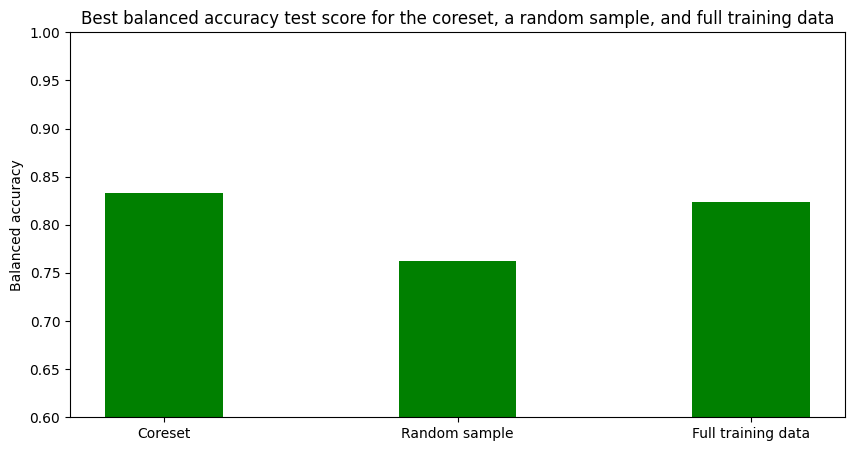

In [13]:
data = {'Coreset':coreset_best_params_test_score, 'Random sample':random_sample_best_params_test_score,
        'Full training data':full_best_params_test_score}
datasets = list(data.keys())
scores = list(data.values())

fig = plt.figure(figsize=(10, 5))
ax = plt.gca()
ax.set_ylim([0.6, 1.0])
plt.bar(datasets, scores, color='green', width=0.4)
 
plt.ylabel("Balanced accuracy")
plt.title("Best balanced accuracy test score for the coreset, a random sample, and full training data")
plt.show()

### Plot the execution time

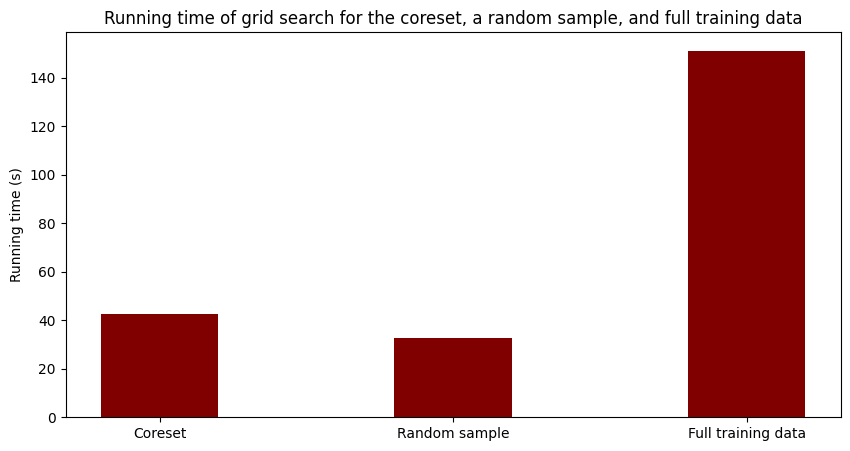

In [14]:
data = {'Coreset':coreset_grid_search_time, 'Random sample':random_grid_search_time,
        'Full training data':full_grid_search_time}
datasets = list(data.keys())
times = list(data.values())

fig = plt.figure(figsize=(10, 5))
plt.bar(datasets, times, color='maroon', width=0.4)
 
plt.ylabel("Running time (s)")
plt.title("Running time of grid search for the coreset, a random sample, and full training data")
plt.show()

### Compute test scores for every combination of hyperparameters from the grid

In [15]:
params_names = list(param_grid.keys())
params_values = param_grid.values()
params_values_combinations = itertools.product(*params_values)
test_scores_coreset = []
test_scores_random = []
test_scores_full = []
balanced_accuracy_scoring = make_scorer(balanced_accuracy_score)
for params_values_combination in params_values_combinations:
    model_params = dict(zip(params_names, params_values_combination))
    print(f'Perform training and testing with hyperparameters {model_params}')
    
    trained_model = service_obj.fit(level=2, **model_params)
    y_pred = trained_model.predict(X_test)
    score_coreset = balanced_accuracy_score(y_test, y_pred)
    test_scores_coreset.append(score_coreset)

    model = XGBClassifier(**model_params)
    model.fit(X_random, y_random)
    y_pred = model.predict(X_test)
    score_random = balanced_accuracy_score(y_test, y_pred)
    test_scores_random.append(score_random)
    
    model = XGBClassifier(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score_full = balanced_accuracy_score(y_test, y_pred)
    test_scores_full.append(score_full)

Perform training and testing with hyperparameters {'lambda': 10, 'max_depth': 3}
Using XGBClassifier model. To use a different model, please set the model parameter. E.g.: service_obj.fit(model=LGBMClassifier(**params), **other_params) or set the model_cls during init or use the set_model_cls function
Perform training and testing with hyperparameters {'lambda': 10, 'max_depth': 6}
Using XGBClassifier model. To use a different model, please set the model parameter. E.g.: service_obj.fit(model=LGBMClassifier(**params), **other_params) or set the model_cls during init or use the set_model_cls function
Perform training and testing with hyperparameters {'lambda': 100, 'max_depth': 3}
Using XGBClassifier model. To use a different model, please set the model parameter. E.g.: service_obj.fit(model=LGBMClassifier(**params), **other_params) or set the model_cls during init or use the set_model_cls function
Perform training and testing with hyperparameters {'lambda': 100, 'max_depth': 6}
Using XG

### Plot the validation and test scores
The validation scores were extracted from the output of the grid search methods

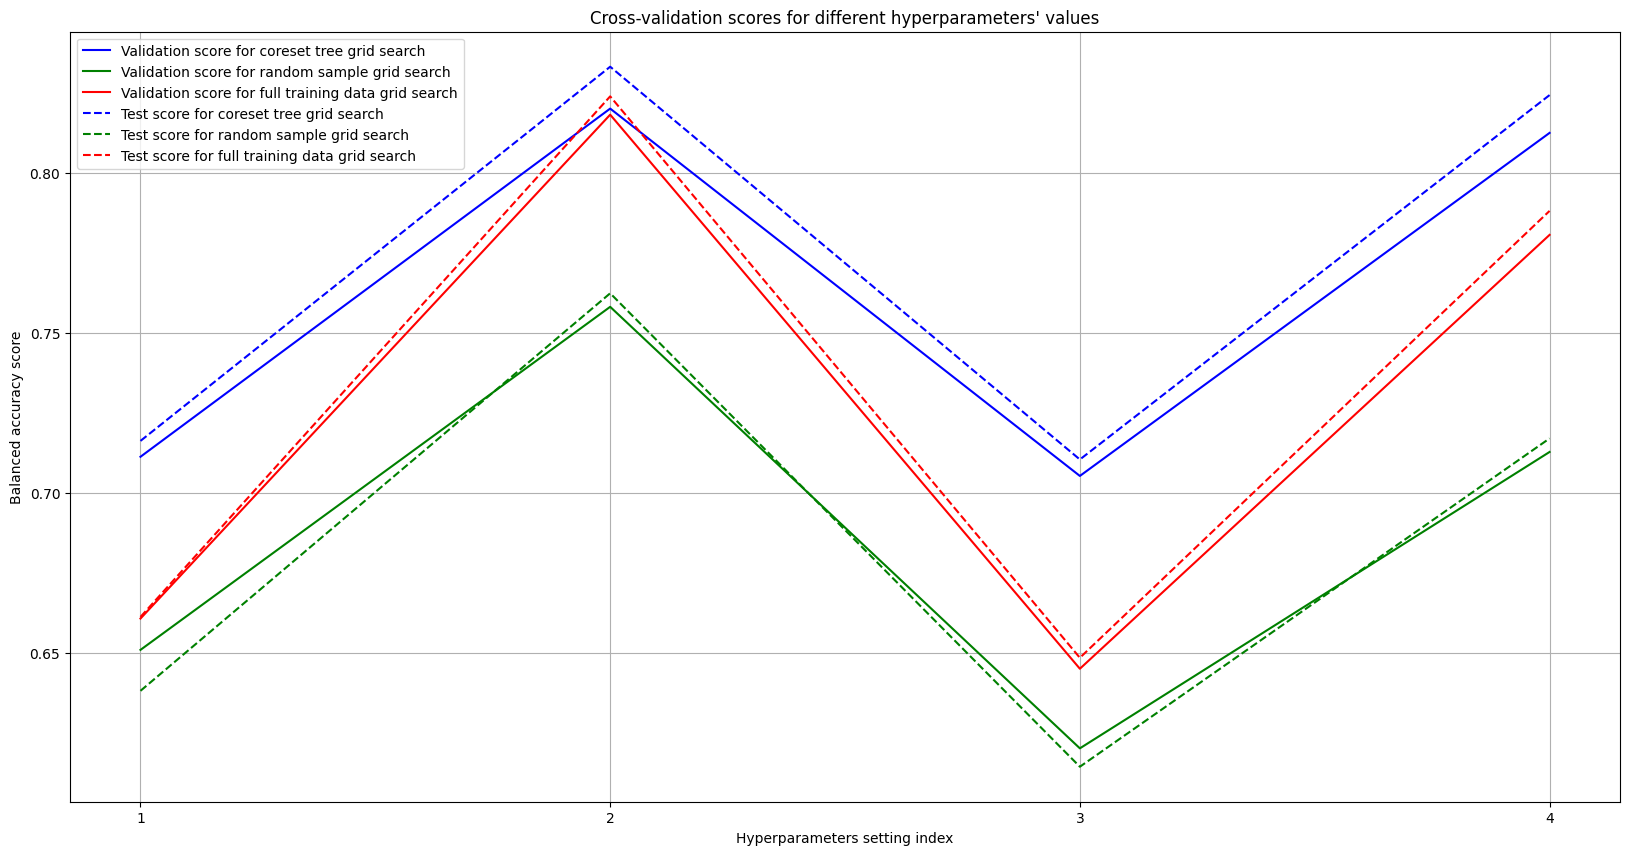

In [16]:
fig_scores, axd_scores = plt.subplots(figsize=(20, 10))

indexes = np.array(range(len(test_scores_coreset))) + 1
axd_scores.plot(indexes, validation_scores_coreset, label=f"Validation score for coreset tree grid search", color="blue")
axd_scores.plot(indexes, validation_scores_random, label=f"Validation score for random sample grid search", color="green")
axd_scores.plot(indexes, validation_scores_full, label=f"Validation score for full training data grid search", color="red")

axd_scores.plot(indexes, test_scores_coreset, label=f"Test score for coreset tree grid search", color="blue", linestyle='--')
axd_scores.plot(indexes, test_scores_random, label=f"Test score for random sample grid search", color="green", linestyle='--')
axd_scores.plot(indexes, test_scores_full, label=f"Test score for full training data grid search", color="red", linestyle='--')

axd_scores.grid(True)
axd_scores.ticklabel_format(useOffset=False)
axd_scores.set_ylabel('Balanced accuracy score')
axd_scores.set_xlabel("Hyperparameters setting index")
axd_scores.set_xticks(indexes)
axd_scores.legend()
_ = axd_scores.set_title("Cross-validation scores for different hyperparameters' values")